In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from src.generator_correct import DataGenerator
from src.blocks import Autoencoder, ConvDecoder, ConvEncoder
from torchvision import transforms
import pickle


In [2]:
with open("train_loss", "rb") as fp:
    train_loss = pickle.load(fp)
with open("val_loss", "rb") as fp:
    val_loss = pickle.load(fp)
with open("legacy_code/old_model/val_loss_stride.pkl", "rb") as fp:
    val_loss_stride = pickle.load(fp)
with open("legacy_code/old_model/train_loss_stride.pkl", "rb") as fp:
    train_loss_stride = pickle.load(fp)
with open("legacy_code/old_model/val_loss_average.pkl", "rb") as fp:
    val_loss_average = pickle.load(fp)
with open("legacy_code/old_model/train_loss_average.pkl", "rb") as fp:
    train_loss_average = pickle.load(fp)
    

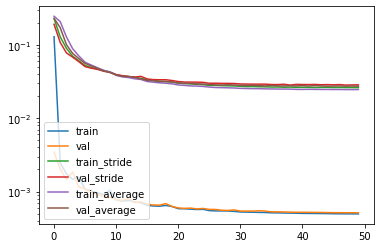

In [3]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.plot(train_loss_stride, label="train_stride")
plt.plot(val_loss_stride, label="val_stride")
plt.plot(train_loss_average, label="train_average")
plt.plot(val_loss_average, label="val_average")
plt.yscale('log')
plt.legend()

In [6]:
min(val_loss)

0.0005136852320120262

In [5]:
path = r"data"
data_df = pd.read_csv(os.path.join(path, "file_info.csv"))

data_df = data_df[data_df["Max_Value"] > 300]

scale = {'x_min': data_df["Min_Value"].min(), "x_max": data_df["Max_Value"].max()}

train_split = 0.7
val_split = 0.15
test_split = 0.15

listIDs = data_df['File_Name'].tolist()

random.seed(333)
random.shuffle(listIDs)

trainIDs = listIDs[:int(round(train_split * len(listIDs)))]
valIDs = listIDs[int(round(train_split * len(listIDs))):int(round((train_split + val_split) * len(listIDs)))]
testIDs = listIDs[int(round((train_split + val_split) * len(listIDs))):]

test_df = data_df[data_df['File_Name'].isin(testIDs)]
weights="best_model_average.pth"

encoder = ConvEncoder(num_channels=64, kernel_size=5, strides=1, pooling=2)
decoder = ConvDecoder(num_channels=64, kernel_size=5, strides=2)
model = Autoencoder(encoder, decoder)

In [6]:
def load_model(weights_path, encoder, decoder):
    model = Autoencoder(encoder, decoder)
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda:0')))
    model.eval()
    return model

def preprocess_image(image_array):
    if image_array.dtype != np.float32:
        image_array = image_array.astype(np.float32)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image_array)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    return image_tensor

def get_prediction(model, image_tensor, device):
    model.to(device)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output.cpu().numpy()

In [7]:
def main():
    idx=np.random.randint(0, len(test_df))
    image_path = os.path.join(path, test_df.iloc[idx]["File_Name"])

    image_array = np.load(image_path)
    image_array =(image_array -scale['x_min'])/(scale['x_max']-scale['x_min'])  # Load your image array here
    weights = "best_model_average.pth"

    encoder = ConvEncoder(num_channels=64, kernel_size=5, strides=1, pooling=2)
    decoder = ConvDecoder(num_channels=64, kernel_size=5, strides=2)
    model = load_model(weights, encoder, decoder)

    image_tensor = preprocess_image(image_array)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    prediction = get_prediction(model, image_tensor, device)
    prediction= prediction * (scale['x_max']-scale['x_min']) + scale['x_min']
    image_array= image_array * (scale['x_max']-scale['x_min']) + scale['x_min']
    return np.squeeze(prediction) , np.squeeze(image_array)

In [12]:
x=np.array([1,2,3,4,5,100])
y=np.array([1,2,3,4,5])

x=(x-np.min(x))/(np.max(x)-np.min(x))
y=(y-np.min(y))/(np.max(y)-np.min(y))


p=np.random.random(len(x))/10
q=np.random.random(len(y))
x,y,p,q

print(np.mean((x-p)**2))
print(np.mean((y-q)**2))


0.1560398713442476
0.24111951074447627


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming prediction and ground_truth are already defined
prediction, ground_truth = main()
print(prediction.shape)
print(ground_truth.shape)

difference = prediction - ground_truth

# Find the global min and max values for the colorbar
vmin = ground_truth.min() 
vmax = ground_truth.max()



fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Ground truth plot
im0 = axs[0].imshow(ground_truth, cmap='gray', vmin=vmin, vmax=vmax)
axs[0].set_title('Ground Truth')

# Prediction plot
im1 = axs[1].imshow(prediction, cmap='gray', vmin=vmin, vmax=vmax)
axs[1].set_title('Prediction')

# Difference plot
im2 = axs[2].imshow(difference, cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title('Difference')

# Add a single colorbar for all images
fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()


(200, 200)
(400, 400)


ValueError: operands could not be broadcast together with shapes (200,200) (400,400) 